# ZIP Code
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

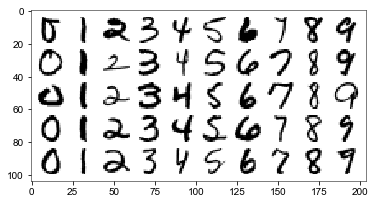

In [3]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
_ = plt.imshow(result, cmap="gray")

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [4]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import math

tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

In [6]:
session = tf.Session()
initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
A = tf.Variable(initializer([256, 10], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 10], dtype=tf.float64))
T = a0 + x @ A
y_hat = tf.nn.softmax(T)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [7]:
train_feed_dict = {x: X_train, y: Y_train_one_hot}
test_feed_dict = {x: X_test}

In [8]:
# let's write a generic training procedure 
def train(optimizer_step):
    accuracy = []
    session.run(tf.global_variables_initializer())
    for e in range(1000):
        session.run(optimizer_step, train_feed_dict)
        y_test_hat = np.argmax(session.run(y_hat, test_feed_dict), axis=1)
        accuracy.append(accuracy_score(y_test, y_test_hat))
    return accuracy

In [20]:
accuracy1 = train(adm)

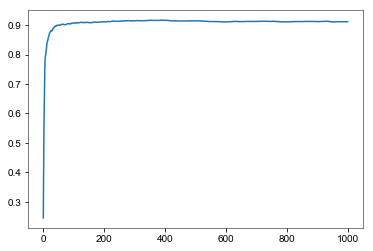

In [21]:
plt.plot(range(1000), accuracy1)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [9]:
n_hidden = 12

A = tf.Variable(initializer([256, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))

Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

y_hat = tf.nn.softmax(T)

cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [10]:
accuracy2 = train(adm)

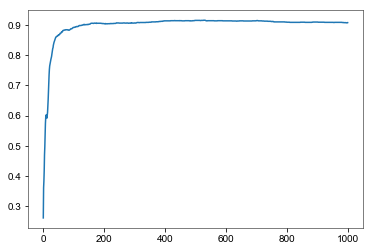

In [11]:
plt.plot(range(1000), accuracy2)